## Processing Sensor Data from Catalina Jemez CZO Green Pit 3
- Marc Berghouse 9/19/2020: Original format
- Zach Perzan 9/23/2020: Improved format and working PRISM concat


This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE

Issues:
- I'm not sure which water potential values are unrealistic
- O2 at 30cm has a weird drop at the beginning

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

def remove_spikes(df, column, window=7, threshold=1):
    """Given a dataframe and column, remove values that are different 
    from the rolling median. For example, with window=5 and threshold=1000 ppm,
    values that are more than 1000 ppm off from the 5-value rolling median will
    be set to NaN.
    
    params: 
        df [dataframe]: dataframe in which the 
        column [str]: name of the column to modify within df
        window [int]: number of records over which to take the median
        threshold [float]: threshold difference above which values are 
            removed (set to NaN)
            
    returns:
        nothing (modifies data in place)
    """
    
    data = df[column].copy()
    
    rollmed = data.rolling(window).median()
    diff = (data - rollmed).abs()
    mask = diff > threshold
    data[mask] = np.nan
    
    df[column] = data

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_co2o2_2018.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit3/Green_pit3_soilMTP_2018.csv"]


# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_Green_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=['ApogeeTemp_2cm.deg.C', 'ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 
            'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100','O2_10cm.percent.0-100',
            'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 'CO2_10cm.ppm', 
            'CO2_30cm.ppm', 'CO2_60cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa',
            'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoistureA_10cm.m3m3',
            'SoilMoistureA_30cm.m3m3', 'SoilMoistureA_60cm.m3m3', 'SoilMoistureA_135cm.m3m3', 
            'BulkECA_10cm.dS/m', 'BulkECA_30cm.dS/m', 'BulkECA_60cm.dS/m', 'BulkECA_135cm.dS/m',
            'Decagon5TETempA_10cm.deg.C','Decagon5TETempA_30cm.deg.C', 'Decagon5TETempA_60cm.deg.C',
            'Decagon5TETempA_135cm.deg.C', 'SoilMoistureB_10cm.m3m3', 'SoilMoistureB_30cm.m3m3',
            'SoilMoistureB_60cm.m3m3', 'SoilMoistureB_135cm.m3m3', 'BulkECB_10cm.dS/m', 
            'BulkECB_30cm.dS/m', 'BulkECB_60cm.dS/m', 'BulkECB_135cm.dS/m', 
            'Decagon5TETempB_10cm.deg.C', 'Decagon5TETempB_30cm.deg.C',
            'Decagon5TETempB_60cm.deg.C','Decagon5TETempB_135cm.deg.C']

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)

ppt = ppt.drop((pd.date_range('2015-01-01', '2015-10-23')), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()


df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

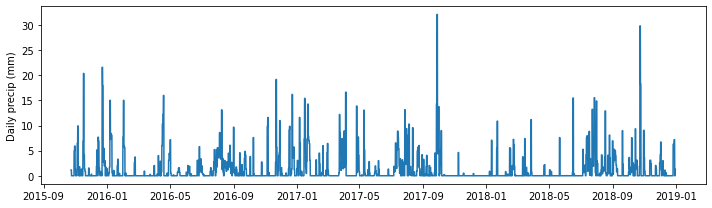

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

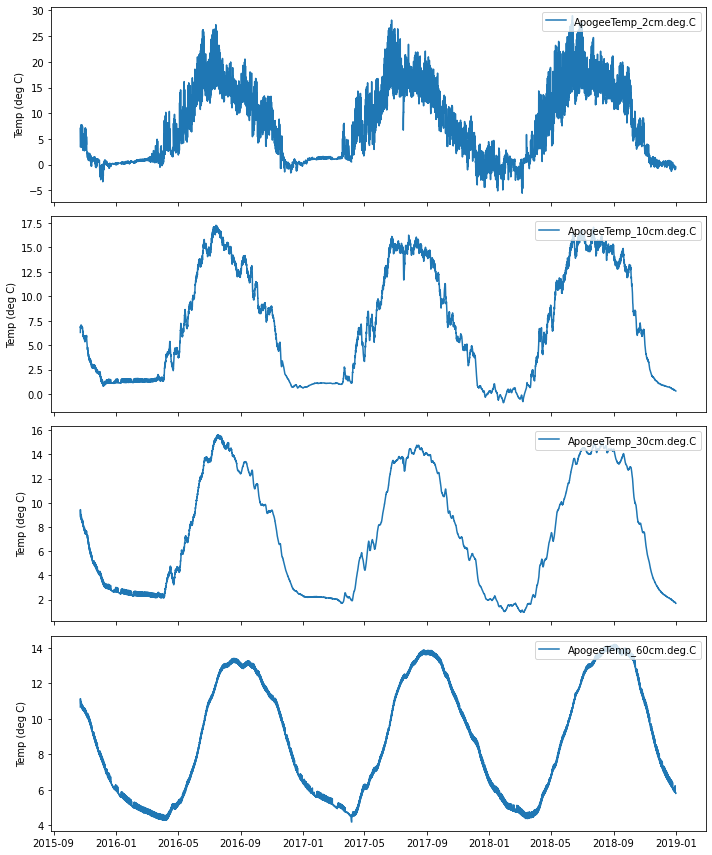

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

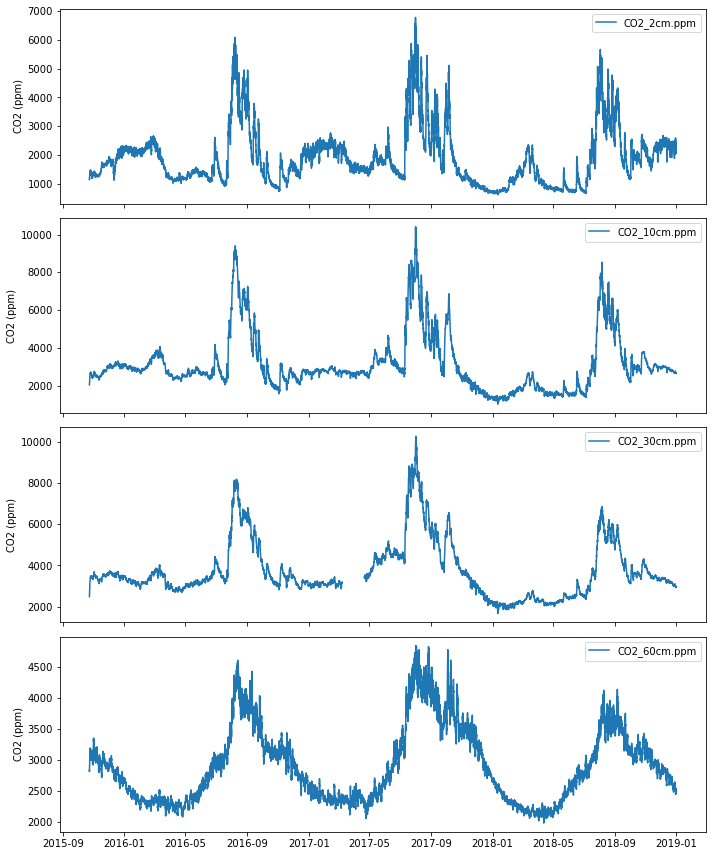

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

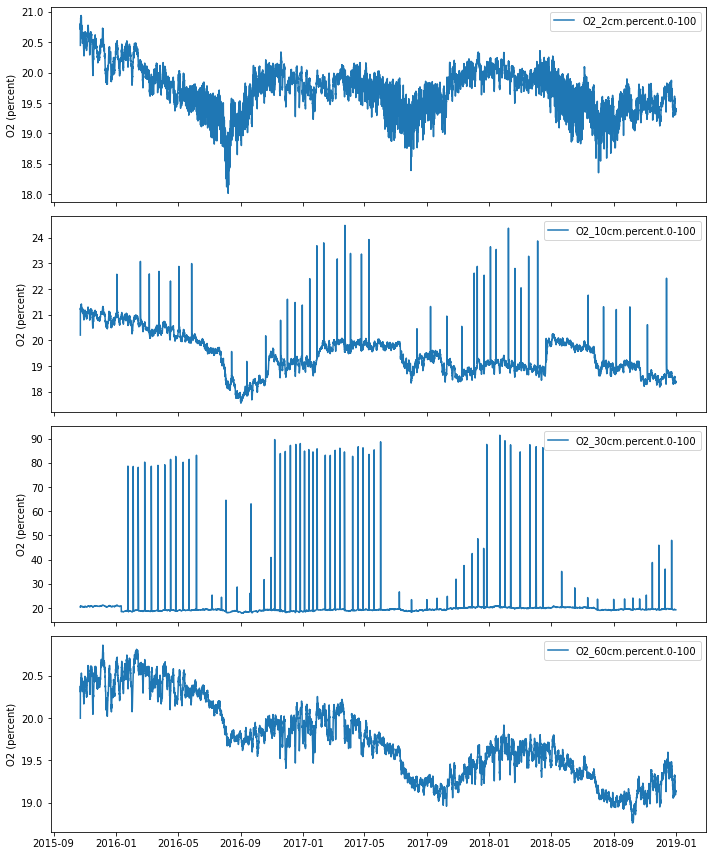

In [7]:
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

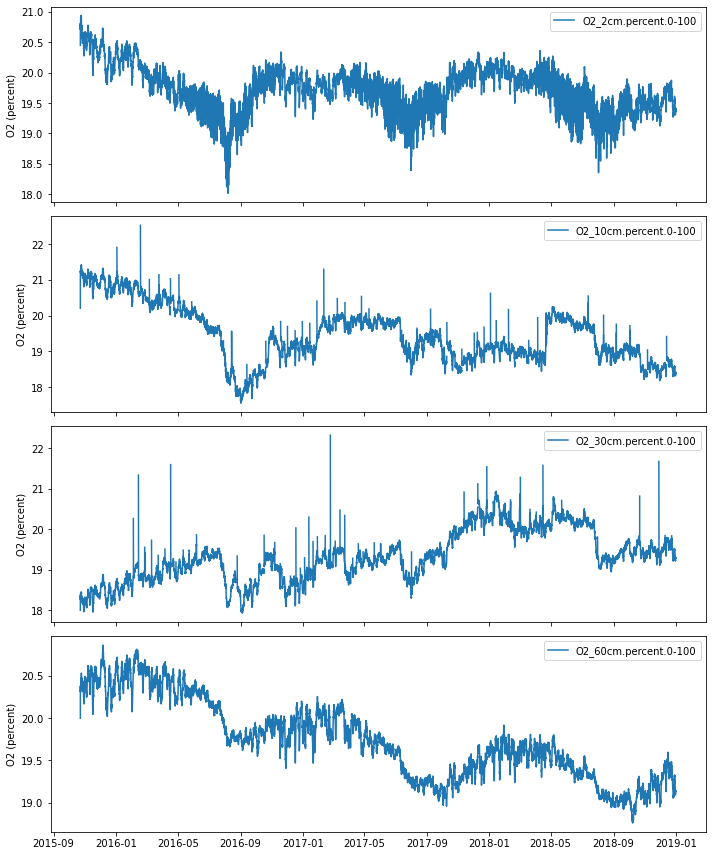

In [8]:
# Plot O2 data
df['O2_2cm.percent.0-100'].mask(df['O2_2cm.percent.0-100']>=23, inplace=True)
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=23, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=23, inplace=True)
df['O2_60cm.percent.0-100'].mask(df['O2_60cm.percent.0-100']>=23, inplace=True)
df.loc[:'2016-01-11 12:00', 'O2_30cm.percent.0-100'] -= 2.3539

remove_spikes(df, 'O2_10cm.percent.0-100', window=7, threshold=1)
remove_spikes(df, 'O2_30cm.percent.0-100', window=7, threshold=1)

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

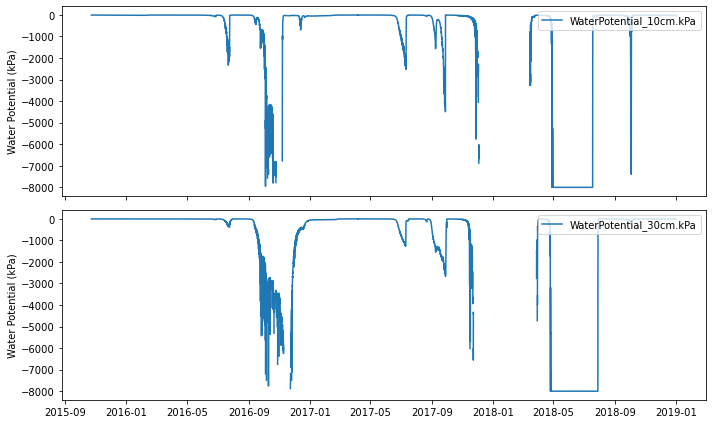

In [9]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

In [10]:
SM_30_a=df.loc['2015-01-09':'2017-01-01', 'SoilMoistureA_30cm.m3m3']
SM_30_b=df.loc['2017-02-01':'2019-01-01', 'SoilMoistureB_30cm.m3m3']
df['SoilMoisture_30cm.m3m3']= pd.concat([SM_30_a, SM_30_b])


EC_30_a=df.loc['2015-01-09':'2017-01-01', 'BulkECA_30cm.dS/m']
EC_30_b=df.loc['2017-02-01':'2019-01-01', 'BulkECB_30cm.dS/m']
df['BulkEC_30cm.dS/m']= pd.concat([EC_30_a, EC_30_b])



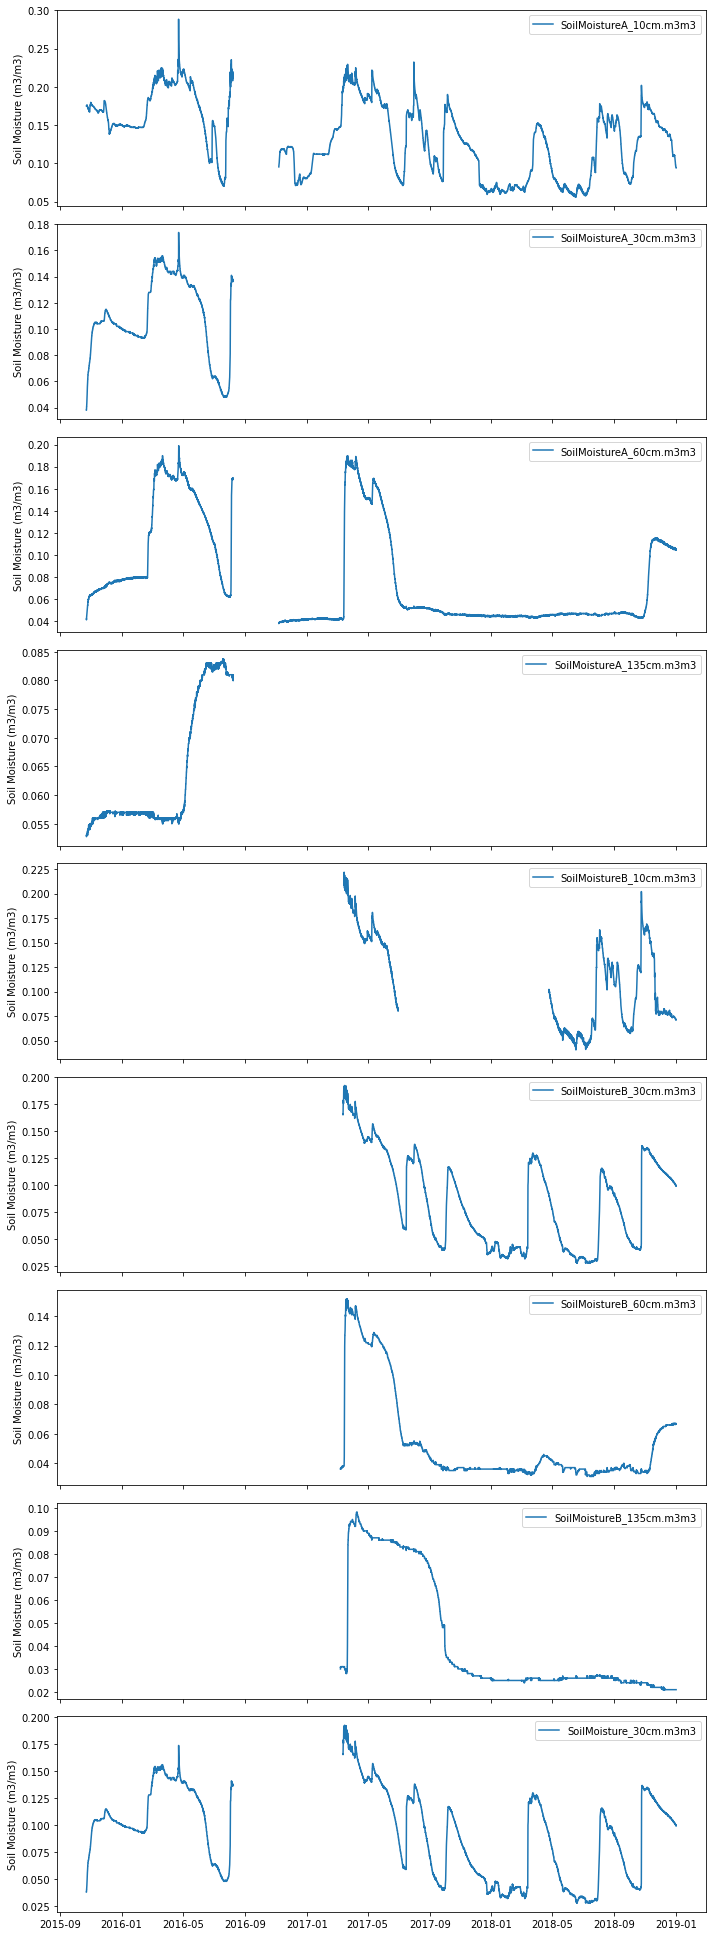

In [11]:
# Plot soil moisture data

sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [12]:
df=df.drop(columns='SoilMoistureA_135cm.m3m3')
df=df.drop(columns='SoilMoistureB_135cm.m3m3')
df=df.drop(columns='SoilMoistureB_60cm.m3m3')
df=df.drop(columns='SoilMoistureB_30cm.m3m3')
df=df.drop(columns='SoilMoistureB_10cm.m3m3')
df=df.drop(columns='SoilMoistureA_30cm.m3m3')

df=df.rename(columns={'SoilMoistureA_10cm.m3m3':'SoilMoisture_10cm.m3m3', 'SoilMoistureA_60cm.m3m3':'SoilMoisture_60cm.m3m3'})

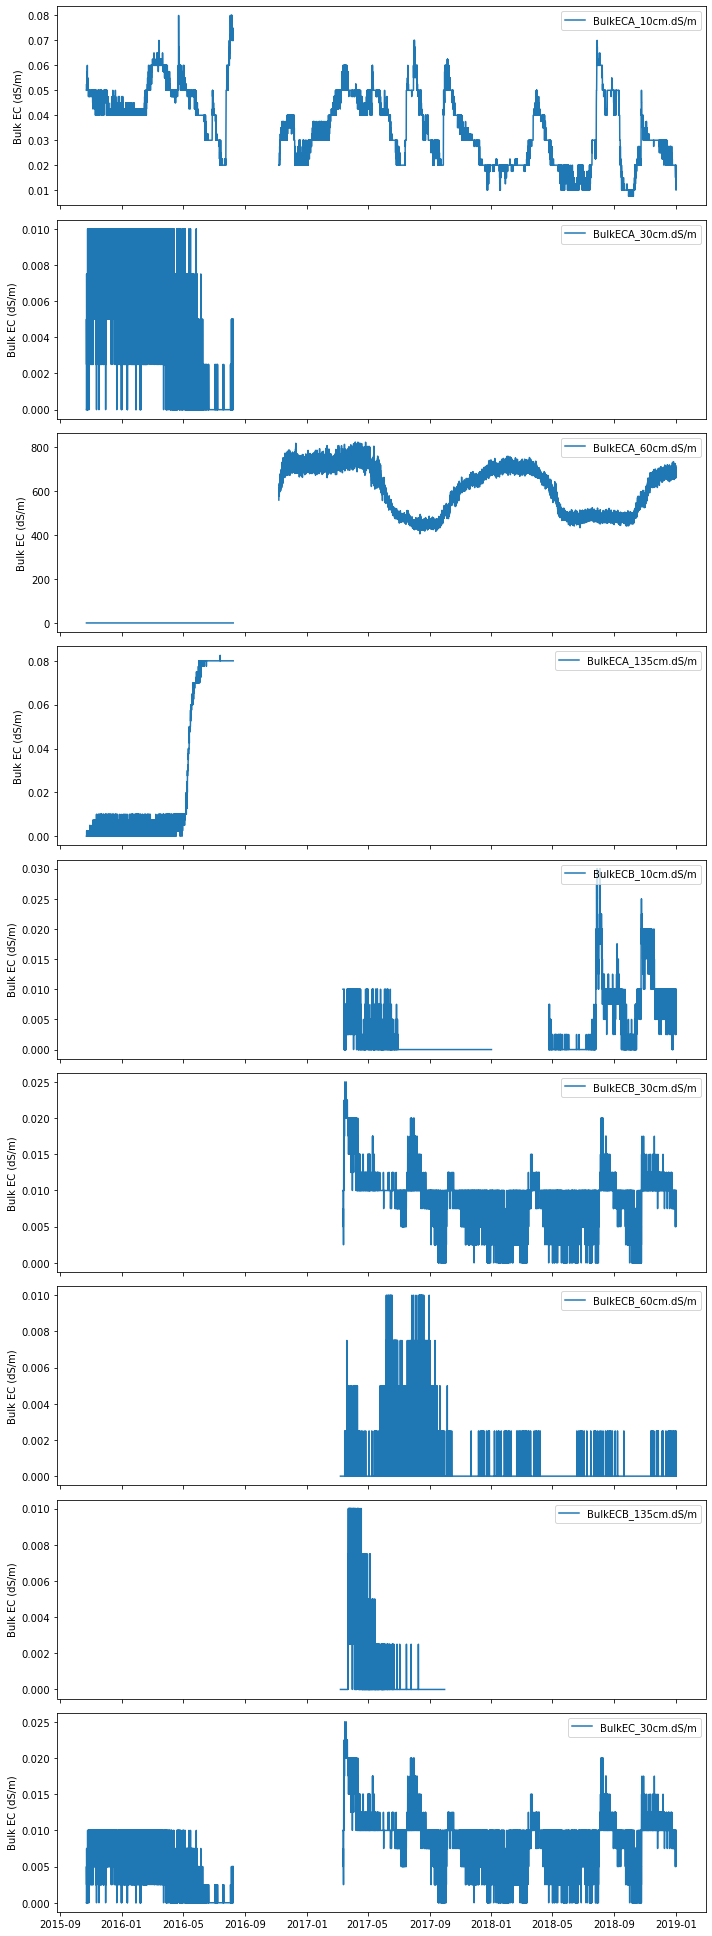

In [13]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [14]:

df=df.drop(columns='BulkECB_135cm.dS/m')
df=df.drop(columns='BulkECA_135cm.dS/m')
df=df.drop(columns='BulkECA_60cm.dS/m')
df=df.drop(columns='BulkECB_30cm.dS/m')
df=df.drop(columns='BulkECA_30cm.dS/m')
df=df.drop(columns='BulkECB_10cm.dS/m')


df=df.rename(columns={'BulkECB_60cm.dS/m':'BulkEC_60cm.dS/m', 'BulkECA_10cm.dS/m':'BulkEC_10cm.dS/m'})

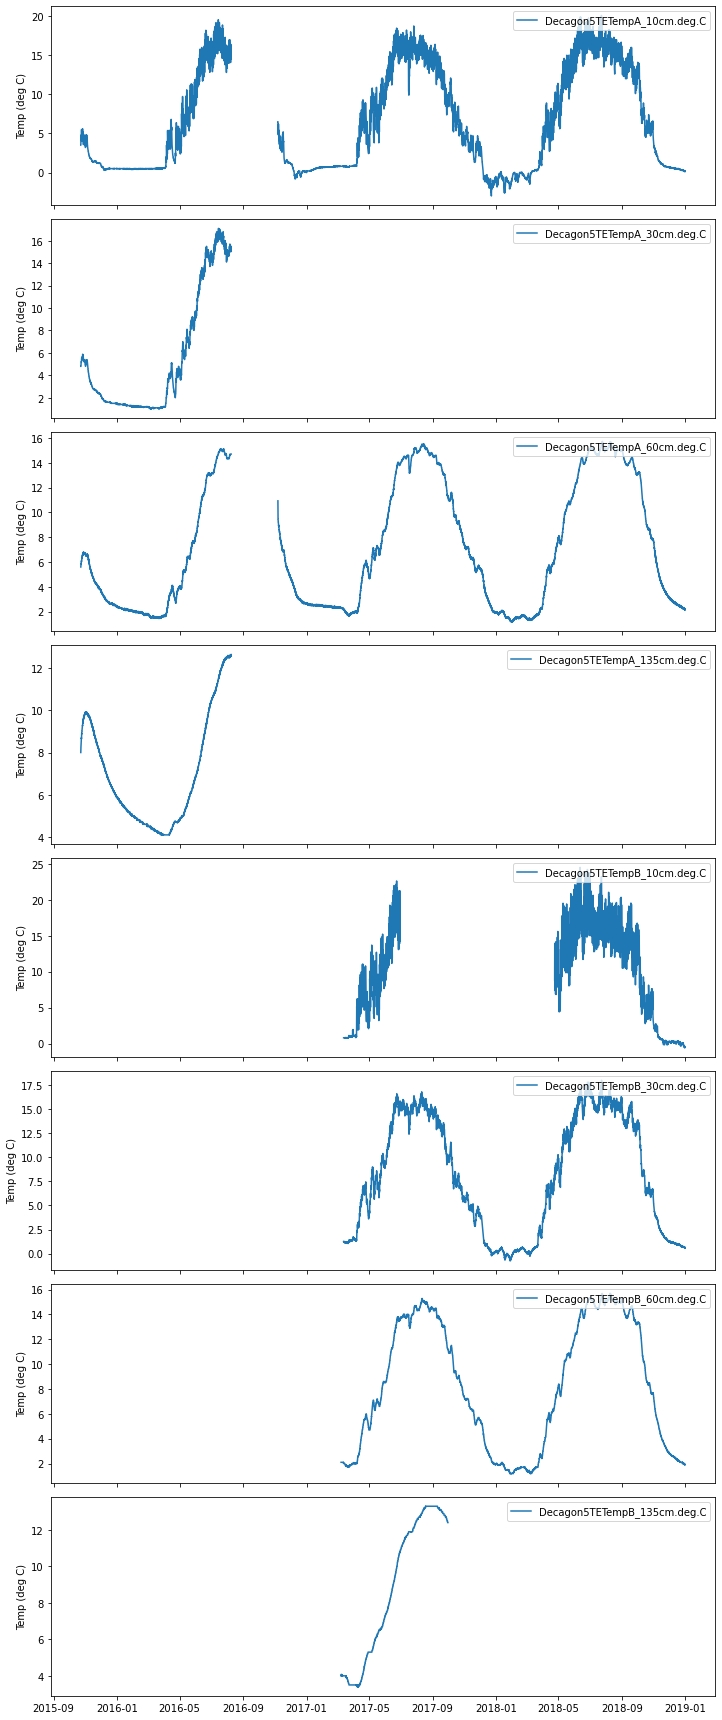

In [15]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [16]:
df=df.drop(columns='Decagon5TETempA_10cm.deg.C')
df=df.drop(columns='Decagon5TETempA_30cm.deg.C')
df=df.drop(columns='Decagon5TETempA_60cm.deg.C')
df=df.drop(columns='Decagon5TETempA_135cm.deg.C')
df=df.drop(columns='Decagon5TETempB_10cm.deg.C')
df=df.drop(columns='Decagon5TETempB_30cm.deg.C')
df=df.drop(columns='Decagon5TETempB_60cm.deg.C')
df=df.drop(columns='Decagon5TETempB_135cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_10cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_30cm.deg.C')




In [17]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/Green_Pit3_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [18]:
output

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,...,CO2_60cm.ppm,WaterPotential_10cm.kPa,WaterPotential_30cm.kPa,SoilMoisture_10cm.m3m3,SoilMoisture_60cm.m3m3,BulkEC_10cm.dS/m,BulkEC_60cm.dS/m,PRISM_precip.mm,SoilMoisture_30cm.m3m3,BulkEC_30cm.dS/m
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2015-10-23 10:00:00,3.52200,6.30500,8.85800,10.66600,20.44800,20.20700,17.99610,19.99800,1160.83700,2033.24100,...,2837.82700,-10.400,-10.000,0.175,0.04200,0.0500,NaN,NaN,0.03800,0.0000
2015-10-23 11:00:00,4.28275,6.75925,9.32875,11.06100,20.80800,21.16525,18.37060,20.35300,1149.10875,2039.14300,...,2811.82875,-10.275,-10.025,0.175,0.04125,0.0500,NaN,NaN,0.03800,0.0000
2015-10-23 12:00:00,4.99325,6.89275,9.43225,11.12575,20.78500,21.24625,18.34710,20.37875,1135.80600,2059.04400,...,2815.98275,-10.300,-10.050,0.175,0.04150,0.0500,NaN,NaN,0.03875,0.0050
2015-10-23 13:00:00,6.05275,6.91075,9.43400,11.13425,20.72775,21.23975,18.30685,20.34100,1145.59750,2081.78575,...,2839.38575,-10.300,-10.000,0.175,0.04200,0.0500,NaN,NaN,0.03900,0.0050
2015-10-23 14:00:00,6.71150,6.92350,9.41925,11.13125,20.70825,21.21575,18.26335,20.31825,1173.55575,2112.98550,...,2847.35200,-10.300,-10.025,0.175,0.04225,0.0500,NaN,NaN,0.03900,0.0025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,-0.54675,0.32225,1.71100,5.81125,19.41025,18.41925,19.30825,19.14225,2199.78425,2648.41600,...,2509.94250,-32.825,-14.925,0.094,0.10525,0.0100,0.0,NaN,0.10000,0.0100
2018-12-31 20:00:00,-0.52500,0.32125,1.70775,5.81000,19.36700,18.41900,19.30750,19.14200,2272.15450,2647.44600,...,2502.67325,-33.100,-14.950,0.094,0.10525,0.0100,0.0,NaN,0.10000,0.0100
2018-12-31 21:00:00,-0.50525,0.31950,1.69925,5.80825,19.36300,18.40525,19.28725,19.14200,2306.25600,2653.57150,...,2528.84200,-33.800,-15.150,0.094,0.10425,0.0150,0.0,NaN,0.09975,0.0100
